In [209]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import gensim
import nlpaug
import nlpaug.augmenter.word as naw
import keras
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from keras.optimizers import Adam

In [175]:
stop = list()
file = open('stopwords_pt.txt',encoding='utf-8')
for word in file.read().splitlines():
    stop.append(word)

In [176]:
data = pd.read_csv('OffComBR3.csv', sep=',')

In [177]:
aug_w2v = naw.WordEmbsAug(
    model_type='fasttext', model_path='cbow_s100.txt',
    action="substitute")

In [181]:
train,valid=train_test_split(data,test_size=0.30)
print('Shape of Train',train.shape)
print("Shape of Validation ",valid.shape)

Shape of Train (723, 2)
Shape of Validation  (310, 2)


In [182]:
train.target.value_counts()

0    584
1    139
Name: target, dtype: int64

In [183]:
from sklearn.utils import shuffle

def augment_text(df,samples=300,pr=0.2):
    aug_w2v.aug_p=pr
    new_text=[]
    
    ##dropping samples from validation
    df_n=df[df.target==1].reset_index(drop=True)

    ## data augmentation loop
    for i in tqdm(np.random.randint(0,len(df_n),samples)):
        
            text = df_n.iloc[i]['tweet_text']
            augmented_text = aug_w2v.augment(text)
            new_text.append(augmented_text)
    
    
    ## dataframe
    new=pd.DataFrame({'tweet_text':new_text,'target':1})
    df=shuffle(df.append(new).reset_index(drop=True))
    return df    

In [184]:
train = augment_text(train,samples=876)

100%|████████████████████████████████████████████████████████████████████████████████| 876/876 [03:10<00:00,  4.60it/s]


In [185]:
train.target.value_counts()

1    1015
0     584
Name: target, dtype: int64

In [187]:
from sklearn.utils import shuffle

def augment_text2(df,samples=300,pr=0.2):
    aug_w2v.aug_p=pr
    new_text=[]
    
    ##dropping samples from validation
    df_n=df[df.target==0].reset_index(drop=True)

    ## data augmentation loop
    for i in tqdm(np.random.randint(0,len(df_n),samples)):
        
            text = df_n.iloc[i]['tweet_text']
            augmented_text = aug_w2v.augment(text)
            new_text.append(augmented_text)
    
    
    ## dataframe
    new=pd.DataFrame({'tweet_text':new_text,'target':0})
    df=shuffle(df.append(new).reset_index(drop=True))
    return df

In [188]:
train = augment_text2(train,samples=401)
data = train.append(valid).reset_index(drop=True)

100%|████████████████████████████████████████████████████████████████████████████████| 401/401 [01:58<00:00,  3.39it/s]


In [189]:
train.target.value_counts()

1    1015
0     985
Name: target, dtype: int64

In [190]:
valid.target.value_counts()

0    247
1     63
Name: target, dtype: int64

In [191]:
data.target.value_counts()

0    1232
1    1078
Name: target, dtype: int64

C:\Users\luisa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Target values')

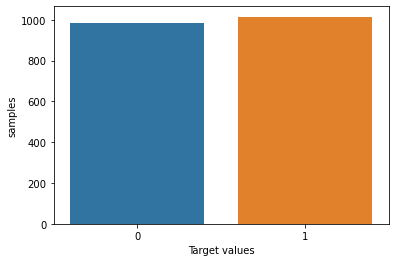

In [192]:
x=train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')
plt.gca().set_xlabel('Target values')

In [193]:
def create_corpus(data):
    corpus=[]
    for tweet in tqdm(data['tweet_text']):
        words=[word.lower() for word in word_tokenize(tweet, language='portuguese') if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [194]:
corpus=create_corpus(data)

100%|████████████████████████████████████████████████████████████████████████████| 2310/2310 [00:01<00:00, 1312.75it/s]


In [195]:
embeddings_index = {}
f = open('cbow_s100.txt',encoding='utf-8')
for line in tqdm(f):
   	values = line.strip().rsplit(' ')
   	word = values[0]
   	coefs = np.asarray(values[1:], dtype='float32')
   	embeddings_index[word] = coefs
f.close()

929606it [01:18, 11899.83it/s]


In [196]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [197]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 4954


In [198]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embeddings_index.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████████████████████████████████████████████████████████████████████| 4954/4954 [00:00<00:00, 160999.40it/s]


In [199]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [200]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           495500    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 576,001
Trainable params: 80,501
Non-trainable params: 495,500
_________________________________________________________________


In [201]:
X_train,y_train = tweet_pad[:train.shape[0]],data['target'][:train.shape[0]]
X_test,y_test= tweet_pad[train.shape[0]:],data['target'][train.shape[0]:]

In [208]:
history=model.fit(X_train,y_train,batch_size=64,epochs=10,validation_data=(X_test,y_test),verbose=2, shuffle=True)

Epoch 1/10
32/32 - 4s - loss: 0.6046 - accuracy: 0.6895 - val_loss: 0.5110 - val_accuracy: 0.7452
Epoch 2/10
32/32 - 6s - loss: 0.5891 - accuracy: 0.7055 - val_loss: 0.5047 - val_accuracy: 0.7355
Epoch 3/10
32/32 - 8s - loss: 0.5742 - accuracy: 0.7200 - val_loss: 0.5054 - val_accuracy: 0.7258
Epoch 4/10
32/32 - 8s - loss: 0.5714 - accuracy: 0.7215 - val_loss: 0.5108 - val_accuracy: 0.7194
Epoch 5/10
32/32 - 7s - loss: 0.5654 - accuracy: 0.7220 - val_loss: 0.5121 - val_accuracy: 0.7194
Epoch 6/10
32/32 - 7s - loss: 0.5536 - accuracy: 0.7265 - val_loss: 0.5177 - val_accuracy: 0.7161
Epoch 7/10
32/32 - 9s - loss: 0.5452 - accuracy: 0.7300 - val_loss: 0.5126 - val_accuracy: 0.7258
Epoch 8/10
32/32 - 9s - loss: 0.5466 - accuracy: 0.7325 - val_loss: 0.5152 - val_accuracy: 0.7226
Epoch 9/10
32/32 - 10s - loss: 0.5381 - accuracy: 0.7285 - val_loss: 0.5109 - val_accuracy: 0.7290
Epoch 10/10
32/32 - 9s - loss: 0.5262 - accuracy: 0.7615 - val_loss: 0.4996 - val_accuracy: 0.7419


In [206]:
y_pre=model.predict(X_test)
y_pre=np.round(y_pre).astype(int).reshape(310)

In [207]:
print(roc_auc_score(y_pre,y_test))

0.6632702571567201


In [210]:
print(cohen_kappa_score(y_test, y_pre))

0.35180345007841074
